# Analyse the similarity of real column vs. synthetic column 

In [1]:
import json
import pandas as pd
import pprint
import matplotlib.pyplot as plt

In [2]:
ALL_TABULAR_DATASETS = ["adult", "census", "child", "covtype", "credit", "insurance", 
                       "health_insurance", "intrusion", "drugs", "loan", "pums"]
ALL_TABULAR_MODELS = {
    "gretel": ["actgan"], 
    "sdv": ["ctgan", "tvae", "gaussian_copula"], 
    "syn": ["ctgan", "tvae", "goggle", "arf", "ddpm", "nflow", "rtvae"], 
    "llm": ["great"], 
    "betterdata": ["gan", "gan_dp"]
}

In [3]:
def get_col_scores(exp_dataset, models_list, metric_name):
    # Initialize dictionary to store output scores
    score_out = {
        "model": [],
        "column": [],
        "exp_dataset": [],
        metric_name: []
    }

    # Iterate through each library and its models
    for lib, models in models_list.items():
        for model in models:
            # Define the path to the metrics file
            metrics_file = f"../metrics_out/tabular/{model}_{lib}/{exp_dataset}/{exp_dataset}_{model}_metrics.json"

            try:
                # Attempt to open and read the metrics file
                with open(metrics_file, 'r') as file:
                    metrics_scores = json.load(file)
            except Exception as e:
                # Uncomment below to print exceptions
                # print(e)
                continue

            # Extract scores from the metrics data
            scores = metrics_scores["sdv_quality_report"]["distribution"]

            # Process each score and append to the output dictionary
            for k, v in scores.items():
                if v["metric"] == metric_name:
                    score_out["model"].append(f"{model}_{lib}")
                    score_out["exp_dataset"].append(exp_dataset)
                    score_out["column"].append(k)
                    score_out[metric_name].append(v["score"])

    return score_out

In [4]:
def plot_col_distribution(df, metric_name):
    
    # Plotting
    plt.figure(figsize=(10, 6))
    for model in df['model'].unique():
        subset = df[df['model'] == model]
        plt.plot(subset['column'], subset[metric_name], marker='o', label=model)

    plt.xlabel('Column')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} by Column for Different Models')
    # plt.legend()

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### TVComplement analysis for categorical columns with high cardinality 
This metric computes the similarity of a real column vs. a synthetic column in terms of the column shapes -- aka the marginal distribution or 1D histogram of the column.

This test computes the Total Variation Distance (TVD) between the real and synthetic columns. 


https://docs.sdv.dev/sdmetrics/metrics/metrics-glossary/tvcomplement

In [5]:
cat_col_tabular_df = pd.DataFrame()
for exp_dataset in ALL_TABULAR_DATASETS:
    final_report = get_col_scores(exp_dataset, ALL_TABULAR_MODELS, "TVComplement") 
    cat_col_tabular_df = pd.concat([cat_col_tabular_df, pd.DataFrame(final_report)], ignore_index=True)
cat_col_tabular_df

,model,column,exp_dataset,TVComplement
0,actgan_gretel,workclass,adult,0.910640
1,actgan_gretel,education,adult,0.922923
2,actgan_gretel,marital-status,adult,0.926915
3,actgan_gretel,occupation,adult,0.912022
4,actgan_gretel,relationship,adult,0.883157
...,...,...,...,...
1991,gaussian_copula_sdv,ABSENT,pums,0.412384
1992,gaussian_copula_sdv,LOOKING,pums,0.525901
1993,gaussian_copula_sdv,AVAILBLE,pums,0.905067
1994,gaussian_copula_sdv,WRKRECAL,pums,0.908888


### Analysis on datasets

In [6]:
high_cardinality_cols = {
    "adult": ["workclass", "education", "occupation", "native-country"],
    "intrusion": ["service", "flag"],
    "census": ["worker", "education", "major industry code", "major occupation code", "hispanic origin", "full or part time employment stat", "state of previous residence",
              "detailed household and family stat", "detailed household summary in household", "migration code-change in msa", "migration code-change in reg", 
              "migration code-move within reg", "country of birth father", "country of birth mother", "country of birth self"],
    "drugs": ["Residence City", "Residence County", "Residence State", "Death City", "Death County", "Location if Other", "Injury Place", "Injury City", "Injury County", 
             "Other Significant Conditions", "Other"],
    "pums": ["PUMA", "YEAR", "RACE"]
}

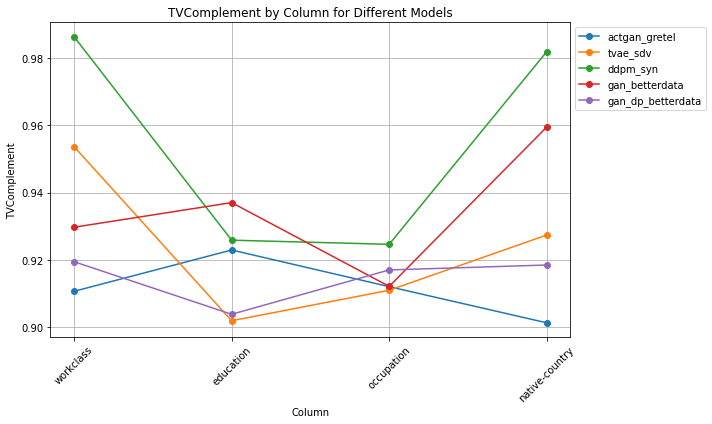

In [7]:
exp_dataset = "adult"
subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset) & (cat_col_tabular_df["column"].isin(high_cardinality_cols[exp_dataset]))]
# subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset)]


# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['TVComplement'] < 0.9
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'TVComplement')

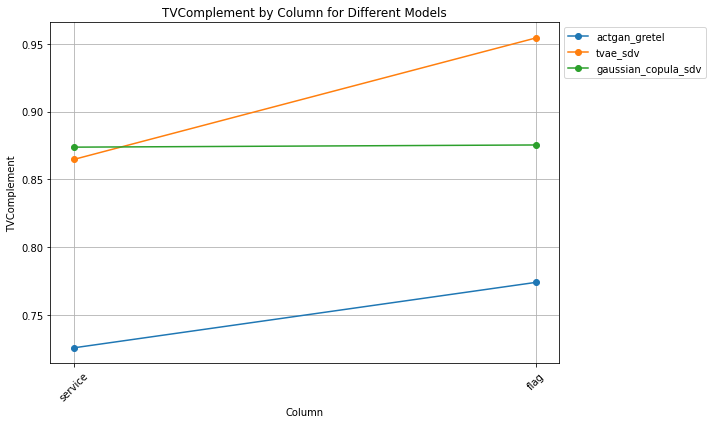

In [8]:
exp_dataset = "intrusion"
subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset) & (cat_col_tabular_df["column"].isin(high_cardinality_cols[exp_dataset]))]


# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['TVComplement'] < 0.7
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]

plot_col_distribution(subset, 'TVComplement')

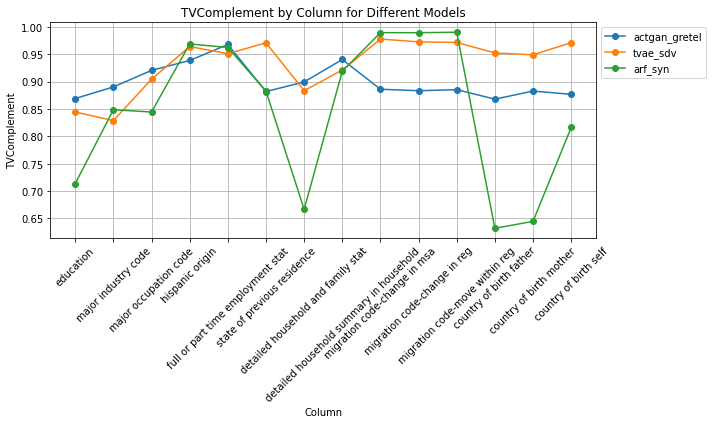

In [9]:
exp_dataset = "census"
subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset) & (cat_col_tabular_df["column"].isin(high_cardinality_cols[exp_dataset]))]


# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['TVComplement'] < 0.6
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'TVComplement')

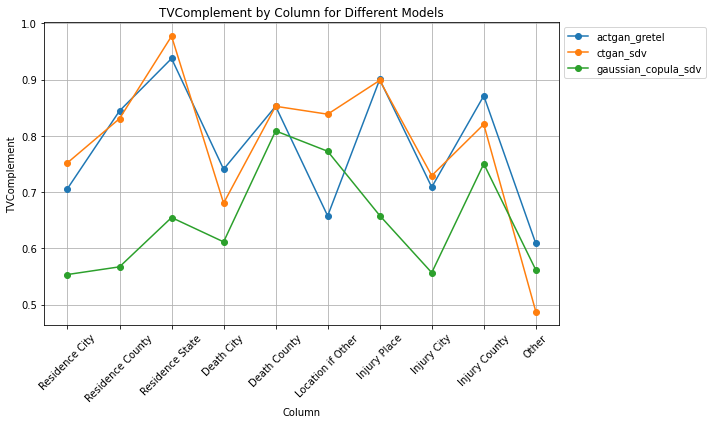

In [10]:
# unjustified
exp_dataset = "drugs"
subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset) & (cat_col_tabular_df["column"].isin(high_cardinality_cols[exp_dataset]))]

# subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset) & (cat_col_tabular_df["model"] == "arf_syn")]


# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['TVComplement'] < 0.3
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]



plot_col_distribution(subset, 'TVComplement')

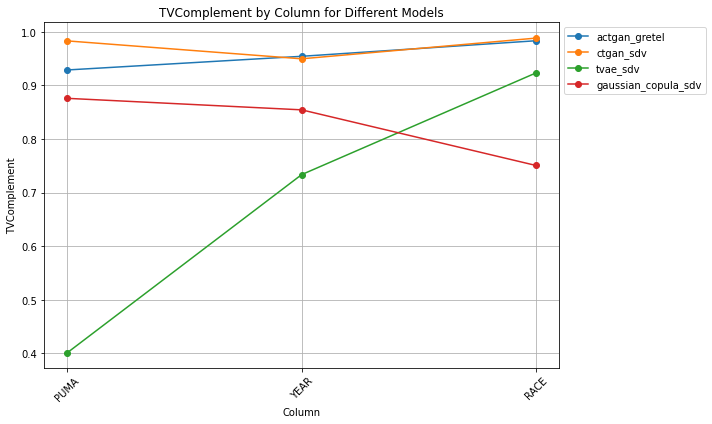

In [11]:
exp_dataset = "pums"
subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset) & (cat_col_tabular_df["column"].isin(high_cardinality_cols[exp_dataset]))]


# Identify the models where any 'KSComplement' value is < 0.5
# mask = subset['TVComplement'] < 0.8
# models_to_drop = subset.loc[mask, 'model'].unique()
# # Drop rows where the model has any 'KSComplement' value < 0.5
# subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'TVComplement')

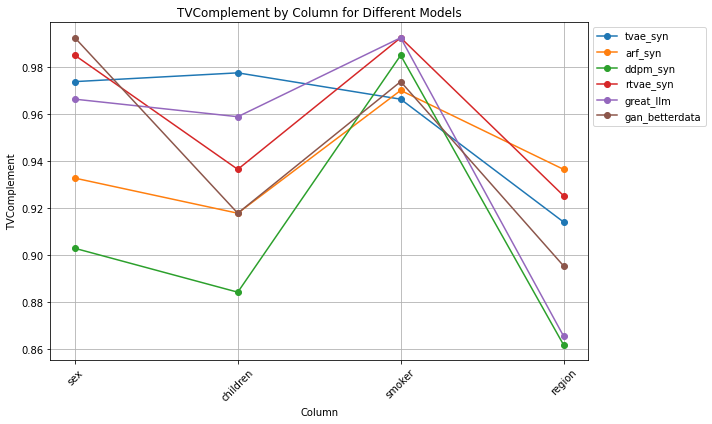

In [12]:
exp_dataset = "health_insurance"
subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset)]


# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['TVComplement'] < 0.85
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'TVComplement')

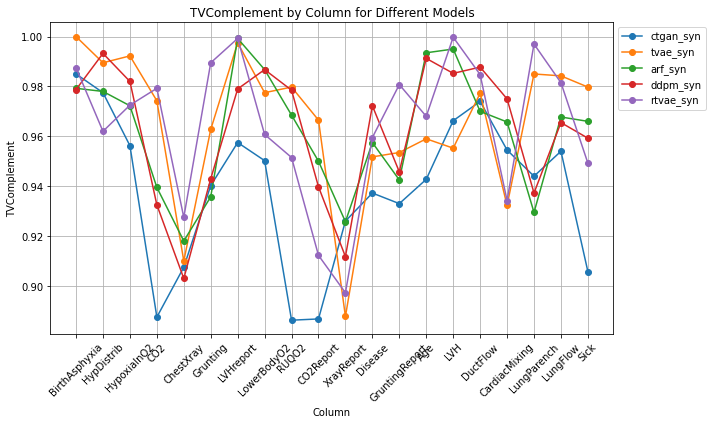

In [13]:
exp_dataset = "child"
subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset)]
# subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset) & (cat_col_tabular_df["model"] == "ddpm_syn")]


# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['TVComplement'] < 0.8
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


# arf_syn, ddpm_syn, || ctgan_syn
plot_col_distribution(subset, 'TVComplement')

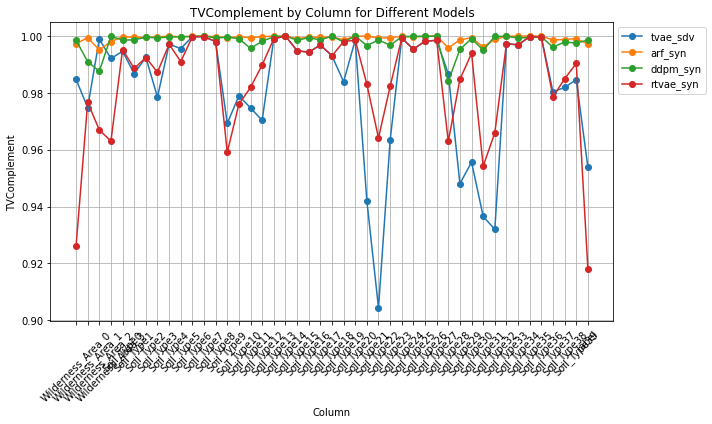

In [14]:
exp_dataset = "covtype"
subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset)]


# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['TVComplement'] < 0.9
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'TVComplement')

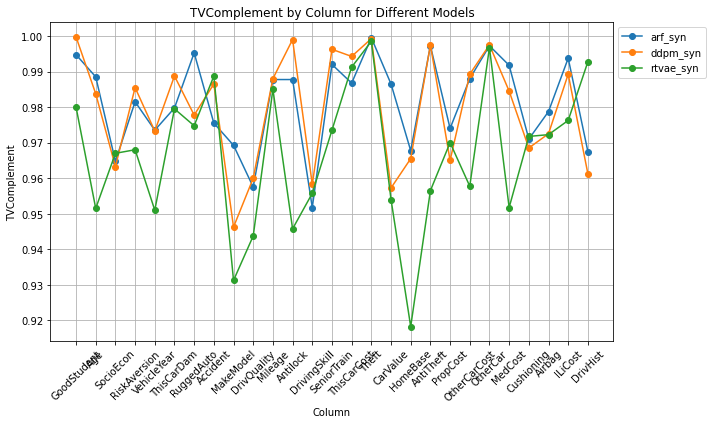

In [15]:
exp_dataset = "insurance"
subset = cat_col_tabular_df[(cat_col_tabular_df["exp_dataset"] == exp_dataset)]

# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['TVComplement'] < 0.9
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'TVComplement')

### KSComplement analysis for numerical columns 

This metric computes the similarity of a real column vs. a synthetic column in terms of the column shapes -- aka the marginal distribution or 1D histogram of the column.
The KSComplement uses the Kolmogorov-Smirnov statistic. https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

https://docs.sdv.dev/sdmetrics/metrics/metrics-glossary/kscomplement

In [16]:
num_col_tabular_df = pd.DataFrame()
for exp_dataset in ALL_TABULAR_DATASETS:
    final_report = get_col_scores(exp_dataset, ALL_TABULAR_MODELS, "KSComplement") 
    num_col_tabular_df = pd.concat([num_col_tabular_df, pd.DataFrame(final_report)], ignore_index=True)
num_col_tabular_df

,model,column,exp_dataset,KSComplement
0,actgan_gretel,age,adult,0.899893
1,actgan_gretel,fnlwgt,adult,0.860587
2,actgan_gretel,education-num,adult,0.960694
3,actgan_gretel,capital-gain,adult,0.297405
4,actgan_gretel,capital-loss,adult,0.830032
...,...,...,...,...
703,gaussian_copula_sdv,INCEARN,pums,0.817297
704,gaussian_copula_sdv,POVERTY,pums,0.715221
705,gaussian_copula_sdv,DEPARTS,pums,0.571380
706,gaussian_copula_sdv,ARRIVES,pums,0.555320


### Analysis on datasets

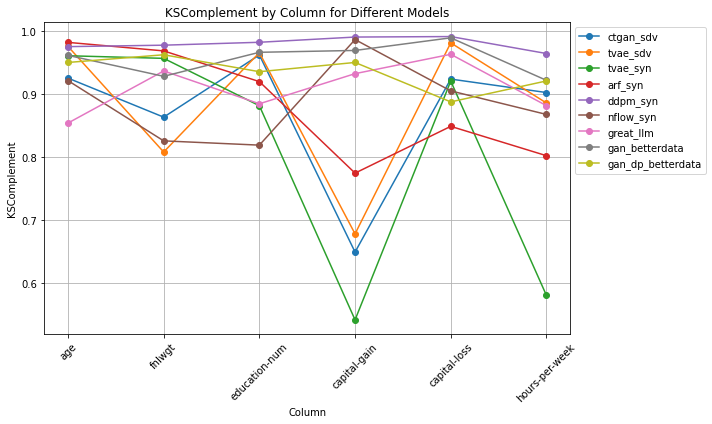

In [17]:
exp_dataset = "adult"
subset = num_col_tabular_df[(num_col_tabular_df["exp_dataset"] == exp_dataset)]

# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['KSComplement'] < 0.5
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'KSComplement')

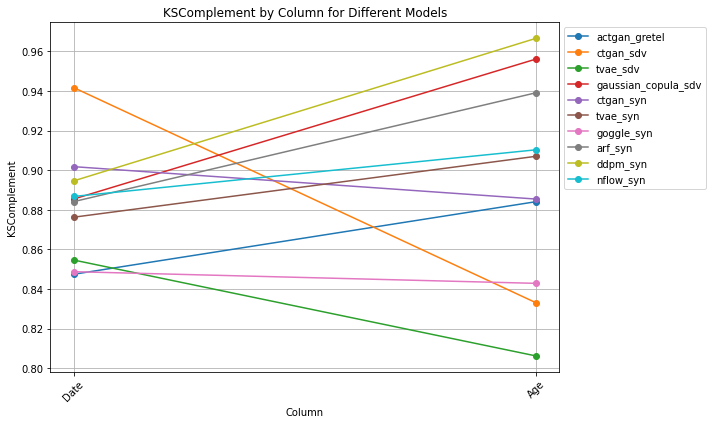

In [18]:
exp_dataset = "drugs"
subset = num_col_tabular_df[(num_col_tabular_df["exp_dataset"] == exp_dataset)]

# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['KSComplement'] < 0.8
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]

plot_col_distribution(subset, 'KSComplement')

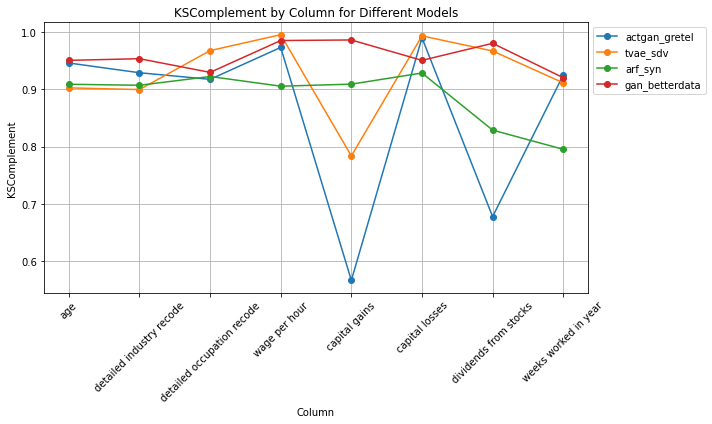

In [19]:
exp_dataset = "census"
subset = num_col_tabular_df[(num_col_tabular_df["exp_dataset"] == exp_dataset)]

# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['KSComplement'] < 0.5
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'KSComplement')

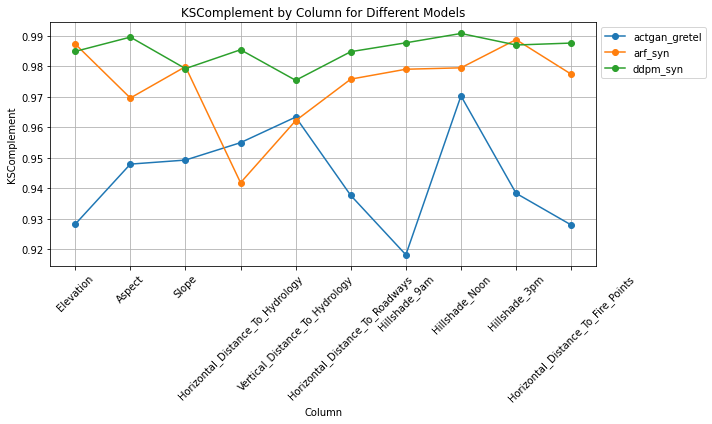

In [20]:
exp_dataset = "covtype"
subset = num_col_tabular_df[(num_col_tabular_df["exp_dataset"] == exp_dataset)]

# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['KSComplement'] < 0.9
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'KSComplement')

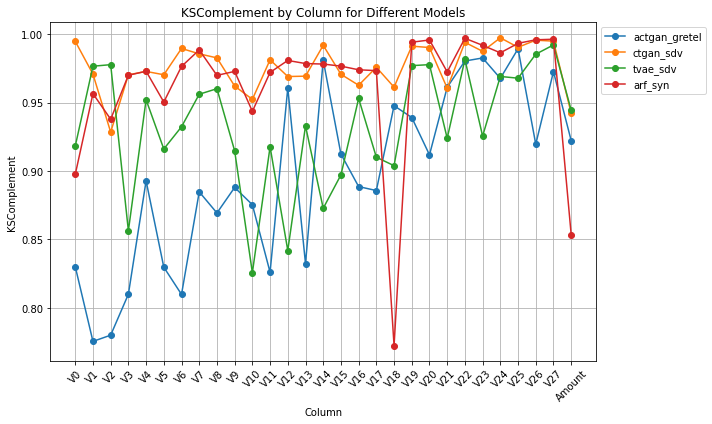

In [21]:
exp_dataset = "credit"
subset = num_col_tabular_df[(num_col_tabular_df["exp_dataset"] == exp_dataset)]

# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['KSComplement'] < 0.75
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'KSComplement')

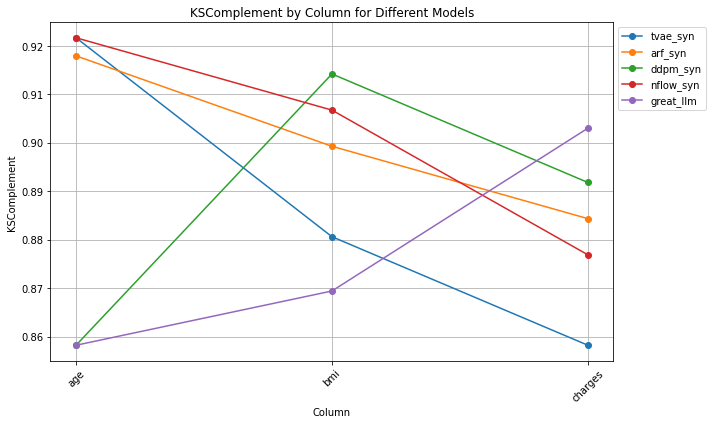

In [22]:
exp_dataset = "health_insurance"
subset = num_col_tabular_df[(num_col_tabular_df["exp_dataset"] == exp_dataset)]

# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['KSComplement'] < 0.85
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]

plot_col_distribution(subset, 'KSComplement')

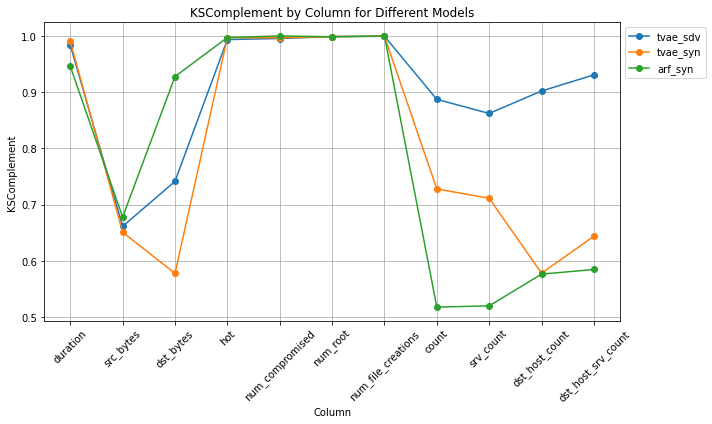

In [23]:
exp_dataset = "intrusion"
subset = num_col_tabular_df[(num_col_tabular_df["exp_dataset"] == exp_dataset)]


# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['KSComplement'] < 0.5
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'KSComplement')

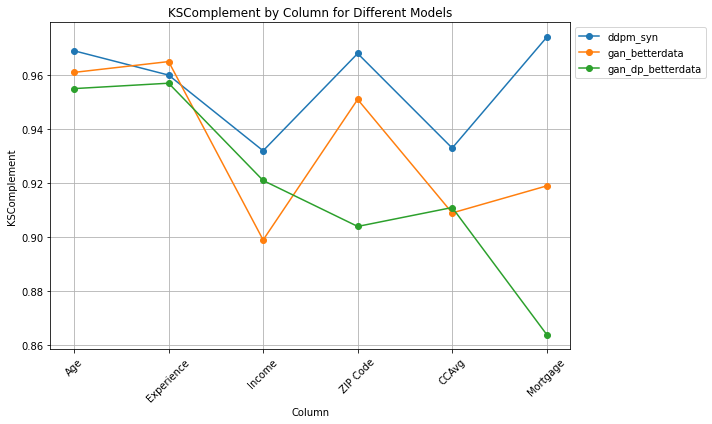

In [24]:
exp_dataset = "loan"
subset = num_col_tabular_df[(num_col_tabular_df["exp_dataset"] == exp_dataset)]
# subset = num_col_tabular_df[(num_col_tabular_df["exp_dataset"] == exp_dataset) & (num_col_tabular_df["model"] == "ddpm_syn")]
# subset = num_col_tabular_df[(num_col_tabular_df["exp_dataset"] == exp_dataset) & (num_col_tabular_df["KSComplement"] >= 0.9)]

# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['KSComplement'] < 0.85
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]


plot_col_distribution(subset, 'KSComplement')

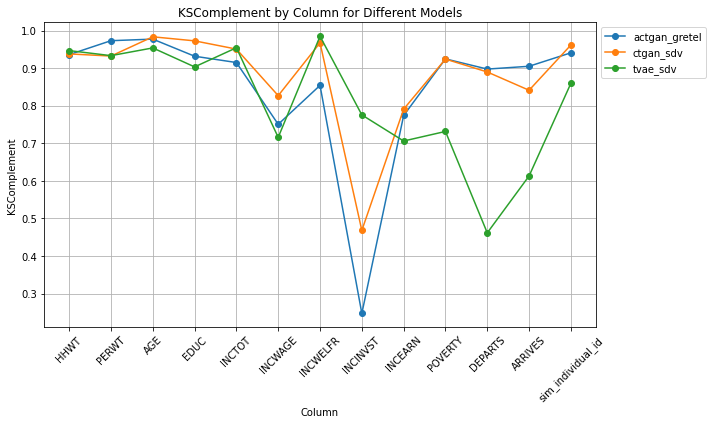

In [25]:
exp_dataset = "pums"
subset = num_col_tabular_df[(num_col_tabular_df["exp_dataset"] == exp_dataset)]

# Identify the models where any 'KSComplement' value is < 0.5
mask = subset['KSComplement'] < 0.2
models_to_drop = subset.loc[mask, 'model'].unique()
# Drop rows where the model has any 'KSComplement' value < 0.5
subset = subset[~subset['model'].isin(models_to_drop)]

plot_col_distribution(subset, 'KSComplement')